In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import sys

main_dir = ''
func_dir = main_dir + 'utils/'
fig_dir = main_dir + 'results/paper_figures/'
sys.path.insert(0,func_dir)

from neuron_properties_functions import create_empty_mouse_stats_dict, get_split_half_r_all_mice, get_SNR_all_mice, get_max_corr_vals_all_mice, get_evars_all_mice, get_evar_monkey_all_dates, store_mouse_alphas
from neuron_properties_functions import create_empty_monkey_stats_dict, get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates, get_max_corr_vals_monkey_all_dates
from fig_3_functions import store_L23_indices, store_mouse_directionality_alphas, get_directionality_evars_mice, make_mouse_df_directionality, plot_directionalities, make_mouse_df
from fig_3_functions import store_V1_indices, store_macaque_directionality_alphas, get_directionality_evars_monkey, make_monkey_df_directionality, make_monkey_df
import mouse_data_functions as cs


## Mouse Directionality

### coding

In [ ]:
mouse_stats= create_empty_mouse_stats_dict(main_dir)
get_SNR_all_mice(main_dir, mouse_stats)
get_split_half_r_all_mice(main_dir, mouse_stats)
get_max_corr_vals_all_mice(main_dir, mouse_stats)

In [3]:
store_L23_indices(mouse_stats)
store_mouse_directionality_alphas(main_dir, mouse_stats, activity_type='resp', verbose=False)
get_directionality_evars_mice(main_dir, mouse_stats, activity_type='resp',control_shuffle=False)
get_directionality_evars_mice(main_dir, mouse_stats, activity_type='spont',control_shuffle=False)
get_directionality_evars_mice(main_dir, mouse_stats, activity_type='resp',control_shuffle=True)
get_directionality_evars_mice(main_dir, mouse_stats, activity_type='spont',control_shuffle=True)

ori32_M160825_MP027_2016-12-15 done
ori32_M170604_MP031_2017-06-26 done
ori32_M170714_MP032_2017-08-02 done
ori32_M170717_MP033_2017-08-17 done
ori32 done
natimg32_M170604_MP031_2017-06-27 done
natimg32_M170714_MP032_2017-08-01 done
natimg32_M170717_MP033_2017-08-25 done
natimg32 done
Took 0.5321 minutes to complete
ori32_M170604_MP031_2017-06-26 done
ori32_M170714_MP032_2017-08-02 done
ori32_M170717_MP033_2017-08-17 done
ori32 done
natimg32_M170604_MP031_2017-06-27 done
natimg32_M170714_MP032_2017-08-01 done
natimg32_M170717_MP033_2017-08-25 done
natimg32 done
Took 0.4877 minutes to complete
ori32_M160825_MP027_2016-12-15 done
ori32_M170604_MP031_2017-06-26 done
ori32_M170714_MP032_2017-08-02 done
ori32_M170717_MP033_2017-08-17 done
ori32 done
natimg32_M170604_MP031_2017-06-27 done
natimg32_M170714_MP032_2017-08-01 done
natimg32_M170717_MP033_2017-08-25 done
natimg32 done
Took 0.5196 minutes to complete
ori32_M170604_MP031_2017-06-26 done
ori32_M170714_MP032_2017-08-02 done
ori32_M170

### plotting

In [3]:
dir_mouse_df_stimulus = make_mouse_df_directionality(mouse_stats_=mouse_stats)


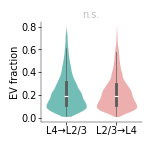

In [4]:
plot_directionalities(dir_mouse_df_stimulus, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction', linewidth=0)

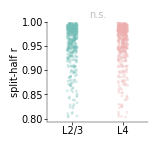

In [5]:
plot_directionalities(dir_mouse_df_stimulus[dir_mouse_df_stimulus['Mouse Name']=='MP033'].reset_index(drop=True), x='Area', neuron_property='Split-half r', 
                    neuron_property_label='split-half r', linewidth=0, plot_control_line=False, 
                    plot_type='stripplot', size=2, alpha=0.3)

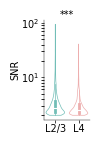

In [5]:
plot_directionalities(dir_mouse_df_stimulus, x='Area', neuron_property='SNR', fig_size=(0.6,1.3),
                      neuron_property_label='SNR', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=True, impose_y_lim=False)

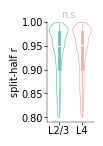

In [6]:
plot_directionalities(dir_mouse_df_stimulus, x='Area', neuron_property='Split-half r', fig_size=(0.6,1.3),
                      neuron_property_label='split-half r', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=True)

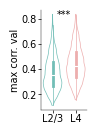

In [7]:
plot_directionalities(dir_mouse_df_stimulus, x='Area', neuron_property='max corr. val', fig_size=(0.6,1.3),
                    neuron_property_label='max corr. val', plot_control_line=False, fill=False, linewidth=0.5, 
                    log_scale=False, impose_y_lim=False, height=0.95)



#### plot supplemental material

In [ ]:
store_mouse_alphas(main_dir, mouse_stats, activity_type='resp', verbose=True)
store_mouse_alphas(main_dir, mouse_stats, activity_type='spont', verbose=True)
get_evars_all_mice(main_dir, mouse_stats, activity_type='resp')
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont')
get_evars_all_mice(main_dir, mouse_stats, activity_type='resp', control_shuffle=True)
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont', control_shuffle=True)


In [8]:
mouse_df_all = make_mouse_df(mouse_stats)
mouse_df=mouse_df_all[(mouse_df_all['SNR']>2) & (mouse_df_all['Split-half r']>0.8)]

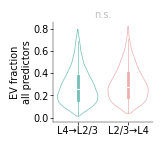

In [9]:
plot_directionalities(mouse_df, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\nall predictors', linewidth=0.5, fill=False)

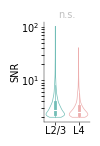

In [10]:
plot_directionalities(mouse_df, x='Area', neuron_property='SNR', fig_size=(0.6,1.3),
                      neuron_property_label='SNR', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=True, impose_y_lim=False)

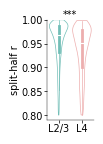

In [11]:
plot_directionalities(mouse_df, x='Area', neuron_property='Split-half r', fig_size=(0.6,1.3),
                      neuron_property_label='split-half r', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=True)

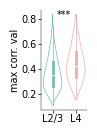

In [12]:
plot_directionalities(mouse_df, x='Area', neuron_property='max corr. val', fig_size=(0.6,1.3),
                      neuron_property_label='max corr. val', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=False, height=0.95)



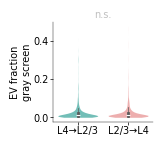

In [13]:
dir_mouse_df_gray_screen = make_mouse_df_directionality(mouse_stats_=mouse_stats, dataset_types=['ori32_spont','natimg32_spont'])

plot_directionalities(dir_mouse_df_gray_screen, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\ngray screen', linewidth=0)


## Macaque Directionality

### coding

In [ ]:

monkey_stats= create_empty_monkey_stats_dict()
get_SNR_monkey_all_dates(monkey_stats)
get_split_half_r_monkey_all_dates(monkey_stats)
get_max_corr_vals_monkey_all_dates(monkey_stats)

In [12]:
store_V1_indices(monkey_stats)
store_macaque_directionality_alphas(monkey_stats)
get_directionality_evars_monkey(monkey_stats, control_shuffle=False)
get_directionality_evars_monkey(monkey_stats, control_shuffle=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Took 3.0960 minutes to complete
Took 3.2729 minutes to complete


### plotting

In [14]:
dir_monkey_df_stimulus = make_monkey_df_directionality(monkey_stats)


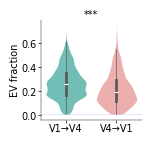

In [15]:
plot_directionalities(dir_monkey_df_stimulus, x='Direction', neuron_property='EV', 
                    neuron_property_label='EV fraction', linewidth=0, animal='monkey')

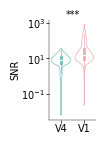

In [16]:
plot_directionalities(dir_monkey_df_stimulus, x='Area', neuron_property='SNR', fig_size=(0.6,1.3),
                    neuron_property_label='SNR', plot_control_line=False, fill=False, linewidth=0.5, 
                    log_scale=True, impose_y_lim=False,animal='monkey')

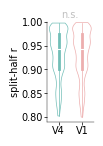

In [17]:
plot_directionalities(dir_monkey_df_stimulus, x='Area', neuron_property='Split-half r', fig_size=(0.6,1.3),
                      neuron_property_label='split-half r', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=True,animal='monkey')

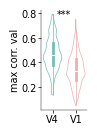

In [18]:
plot_directionalities(dir_monkey_df_stimulus, x='Area', neuron_property='max corr. val', fig_size=(0.6,1.3),
                      neuron_property_label='max corr. val', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=False, height=0.95,animal='monkey')

#### supplemental

In [ ]:
get_evar_monkey_all_dates(monkey_stats, control_shuffle=False)
get_evar_monkey_all_dates(monkey_stats, control_shuffle=True)

In [19]:
df_monkey_all = make_monkey_df(monkey_stats, dataset_types=['SNR', 'RF_thin', 'RF_large'])
df_monkey = df_monkey_all[(df_monkey_all['Split-half r']>0.8)&(df_monkey_all['SNR']>2)]


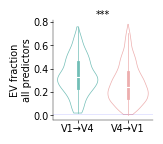

In [20]:
plot_directionalities(df_monkey, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\nall predictors', linewidth=0.5, fill=False,animal='monkey')

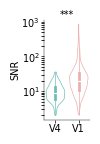

In [21]:
plot_directionalities(df_monkey, x='Area', neuron_property='SNR', fig_size=(0.6,1.3),
                      neuron_property_label='SNR', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=True, impose_y_lim=False,animal='monkey')

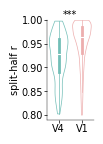

In [22]:
plot_directionalities(df_monkey, x='Area', neuron_property='Split-half r', fig_size=(0.6,1.3),
                      neuron_property_label='split-half r', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=True,animal='monkey')

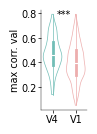

In [23]:
plot_directionalities(df_monkey, x='Area', neuron_property='max corr. val', fig_size=(0.6,1.3),
                      neuron_property_label='max corr. val', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=False, height=0.95,animal='monkey')

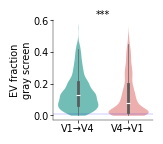

In [24]:
dir_monkey_df_gray_screen = make_monkey_df_directionality(monkey_stats, dataset_types=['SNR_spont','RF_thin_spont','RF_large_spont'])

plot_directionalities(dir_monkey_df_gray_screen, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\ngray screen', linewidth=0,animal='monkey')
plt.savefig(fig_dir +'fig3_monkey_control_evars_GS.eps',transparent=True,bbox_inches='tight' )


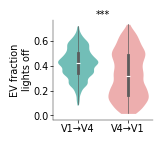

In [25]:
dir_monkey_df_lights_off = make_monkey_df_directionality(monkey_stats, dataset_types=['RS'])
plot_directionalities(dir_monkey_df_lights_off, x='Direction', neuron_property='EV', 
                    neuron_property_label='EV fraction\nlights off', linewidth=0,animal='monkey')
plt.savefig(fig_dir +'fig3_monkey_control_evars_RS.eps',transparent=True,bbox_inches='tight' )
